![Astrofisica Computacional](../../../logo.png)

## 04. Decision Trees for the Bolshoi Simulation

Eduard Larrañaga (ealarranaga@unal.edu.co)



### About this notebook

In this exercise, we will analize some data from the Bolshoi simulation to find a decision tree to classify according to one of the features. 

---

## The Dataset

We will go back to the Bolshoi simulation data studied in a previous lesson. The complete data from the simulation can be found at

http://www.slac.stanford.edu/~behroozi/Bolshoi_Catalogs/  

but we will use again a reduced dataset with approximately 21000 samples. This file is called 'bolshoi01.list' 

Complete information about the Bolshoi simulation can be found in the paper

A. Klypin, S. Trujillo-Gomez, J. Primack. *Halos and galaxies in the standard cosmological model: results from the Bolshoi simulation.*
https://arxiv.org/abs/1002.3660


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

### Loading the data

In order to load the data from the file, we will use the function [numpy.genfromtxt()](https://numpy.org/doc/stable/reference/generated/numpy.genfromtxt.html) which is similar to the function `numpy.loadtxt()`, that we have used before, but gives some options that help when dealing with missing values. 

We will load the first 20000 samples.

In [2]:
#Load data from ascii file
data = np.genfromtxt("BolshoiData/bolshoi01.list",comments='#',max_rows=20000)

From the analysis in a previous lesson, we will consider only some of the features included in the file,

In [3]:
#Extract halo properties

virial_mass   = np.log10(data[:,10])
virial_radius = np.log10(data[:,11])
concentration = np.log10(data[:,11] / data[:,12]) #Concentration is defined as virial radius divided by scale length
velocity_disp = np.log10(data[:,13])
vmax          = np.log10(data[:,16])
spin          = np.log10(data[:,26])
b_to_a        = data[:,44]
c_to_a        = data[:,45]
energy_ratio  = data[:,54]
peak_mass     = np.log10(data[:,58])
peak_vmax     = np.log10(data[:,60])
halfmass_a    = data[:,61]
peakmass_a    = data[:,67]
acc_rate      = data[:,64]

---

## Preparing the data for machine learning

We want to define a decision tree that predicts the `'concentration'`, from the features, `'Half Mass Scale'`,  `'Peak Mass Scale'`, `'B to A ratio'` and `'C to A ratio'`. Hence, we define

In [4]:
features = np.asarray([halfmass_a, peakmass_a, b_to_a, c_to_a])
features = features.T

targets = np.asarray(concentration)

---

## The Decision Tree

Now we will train a decision tree with this information,

In [5]:
from sklearn.tree import DecisionTreeRegressor

d_tree = DecisionTreeRegressor()
d_tree.fit(features, targets)

DecisionTreeRegressor()

This time, we will evaluate the model usint the  [sklearn.metrics.mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) metric.

In [6]:
from sklearn.metrics import mean_squared_error

#Compute Predictions and determine RMSE
predictions = d_tree.predict(features)
tree_mse = mean_squared_error(targets, predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

This value of the rmse is very low! We can see the behavior of the model with a plot:

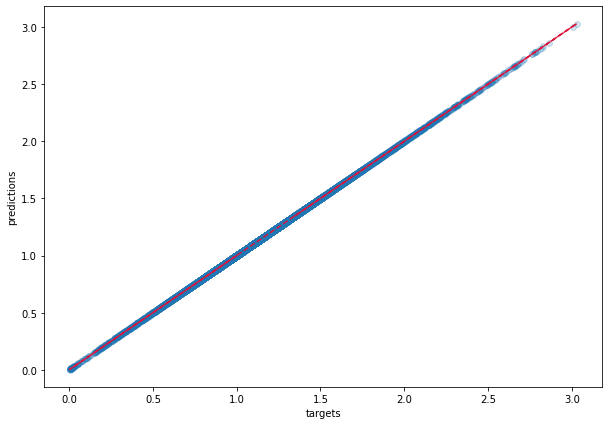

In [7]:
plt.figure(figsize=(10,7))
plt.scatter(targets, predictions, alpha=0.2)
plt.plot(targets, targets, '--', color='crimson')
plt.ylabel(r'predictions')
plt.xlabel(r'targets')
plt.show()

As expected, the result is too good to be true...  

One explanation to what's happening is over-fit... In order to build a better model and to evaluate it we will use the **k fold cross-validation** method. As explained before, this method randomly splits the (training) set into K distinct subsets called **folds** and then, it trains and evaluates the model K times, picking a different fold for every evaluation every time and training on the other K-1 folds. This results in an array with K evaluation scores.

First we will define a function that provides three evaluation parameters: 

- the scores of the k-fold validation
- the mean of these scores
- the standard deviation of the scores

In [8]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())

Now, we calculate the k-fold validation using the funcion [sklearn.model_selection.cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). We will use 10 folds (subsets)

In [9]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(d_tree, features, targets, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores: [0.26115896 0.25732938 0.26209161 0.26975597 0.27106374 0.2774468
 0.29864488 0.29814858 0.28951781 0.32541361]
Mean: 0.2810571346371118
Standard Deviation: 0.02049336425862503


From these results we note that none of the scores is better than the RMSE obtained from the multilinear regression ($\sim 0.2105$). Hence, the linear regressor gives a better model than decision trees for this example.